## Where are the tracers going? (Astoria)


In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import gsw 
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('notebook')
sns.set_style('white')

In [4]:
def plot_transports(dfcan, dfdif, dfcan2, tr, bat, units):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))

    # Tracers
    vertical = (dfdif.Vert_dif_trans_sb + dfcan.Vert_adv_trans_sb)   
    ax0.plot(np.arange(1,19,1)/2.0,(vertical)/1E5,':',color='k')
    ax0.plot(np.arange(1,19,1)/2.0,(dfcan.CS1_adv_trans )/1E5,color='0.4')
    ax0.plot(np.arange(1,19,1)/2.0,(dfcan.CS2_adv_trans )/1E5,color='0.6')
    ax0.plot(np.arange(1,19,1)/2.0,(dfcan.CS3_adv_trans )/1E5,color='0.8')
    ax0.plot(np.arange(1,19,1)/2.0,(dfcan.CS4_adv_trans )/1E5,':',color='0.5')
    ax0.plot(np.arange(1,19,1)/2.0,(dfcan.CS5_adv_trans )/1E5,color='k')

    total = ( (dfcan.CS1_adv_trans ) +
              (dfcan.CS2_adv_trans ) +
              (dfcan.CS3_adv_trans ) +
              (dfcan.CS4_adv_trans ) +
              (dfcan.CS5_adv_trans ) +
               vertical)

    ax0.plot(np.arange(1,19,1)/2.0,total/1E5,'--',color='green')
    ax0.set_xlabel('Days',labelpad=0.5)
    ax0.set_ylabel(units,labelpad=0.5)
    ax0.set_title('%s transports %s' %(tr, bat))

    # Water
    ax1.plot(np.arange(19)/2.0,(dfcan2.Vert_water_trans_sb)/1E4,':',color='k',label = 'LID')
    ax1.plot(np.arange(19)/2.0,(dfcan2.CS1_water_trans)/1E4,color='0.4',label = 'CS1')
    ax1.plot(np.arange(19)/2.0,(dfcan2.CS2_water_trans)/1E4,color='0.6',label = 'CS2')
    ax1.plot(np.arange(19)/2.0,(dfcan2.CS3_water_trans)/1E4,color='0.8',label = 'CS3')
    ax1.plot(np.arange(19)/2.0,(dfcan2.CS4_water_trans)/1E4,':',color='0.5',label= 'CS4')
    ax1.plot(np.arange(19)/2.0,(dfcan2.CS5_water_trans)/1E4,color='k',label = 'CS5')

    total2 = (dfcan2.CS1_water_trans +
              dfcan2.CS2_water_trans +
              dfcan2.CS3_water_trans +
              dfcan2.CS4_water_trans +
              dfcan2.CS5_water_trans +
              dfcan2.Vert_water_trans_sb)

    ax1.plot(np.arange(19)/2.0,total2/1E4,'--',color='green',label = 'Total')
    ax1.set_xlabel('Days',labelpad=0.5)
    ax1.set_ylabel('(10$^{4}$ m$^3$s$^{-1}$)',labelpad=-4)
    ax1.set_title('Water transports %s' %bat)
    ax1.legend(bbox_to_anchor=(1,1))

def tot_trans(dfcan, dfdif):
    vertical = (dfdif.Vert_dif_trans_sb + dfcan.Vert_adv_trans_sb)   
    total = ( (dfcan.CS1_adv_trans ) +
              (dfcan.CS2_adv_trans ) +
              (dfcan.CS3_adv_trans ) +
              (dfcan.CS4_adv_trans ) +
              (dfcan.CS5_adv_trans ) +
               vertical)
    return(total)

def plotCSPos(ax,CS1,CS2,CS3,CS4,CS5):
    ax.axvline(CS1,color='k',linestyle=':')
    ax.axvline(CS2,color='k',linestyle=':')
    ax.axvline(CS3,color='k',linestyle=':')
    ax.axvline(CS4,color='k',linestyle=':')
    ax.axvline(CS5,color='k',linestyle=':')

def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T) + beta*(S))
    return rho
 

In [8]:
#Exp
Grid = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/gridGlob.nc' 
GridOut = Dataset(Grid)

GridNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/gridGlob.nc' 
GridNoCOut = Dataset(GridNoC)

State = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc' 
StateOut = Dataset(State)
StateNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/stateGlob.nc' 

Text(0.5,0,'density / kg m$^{-3}$')

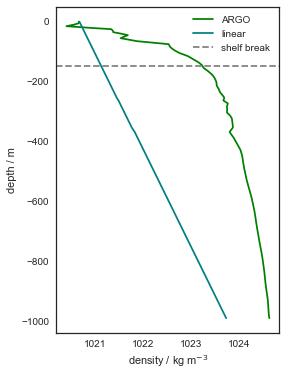

In [25]:
# Stratification comparison, linear vs ARGO

st = xr.open_dataset(State)
st_lin = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc')
gr = xr.open_dataset(Grid)

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

S = st.S[0,:,50,180]
T = st.Temp[0,:,50,180]

dens = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)

S_lin = st_lin.S[0,:,50,180]
T_lin = st_lin.Temp[0,:,50,180]
dens_lin = calc_rho(RhoRef,T_lin,S_lin,alpha=2.0E-4, beta=7.4E-4)

fig, ax = plt.subplots(1,1,figsize=(4,6))

ax.plot(dens[:-10],gr.RC[:-10], color='g', label='ARGO')
ax.plot(dens_lin[:-10],gr.RC[:-10], color='teal', label='linear')
ax.axhline(-150, color='0.5', linestyle='--', label='shelf break')
ax.legend()
ax.set_ylabel('depth / m')
ax.set_xlabel('density / kg m$^{-3}$')


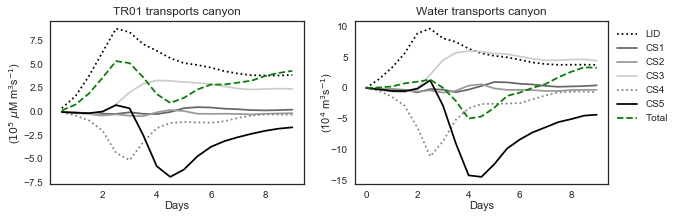

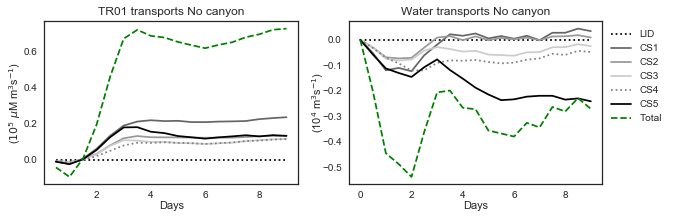

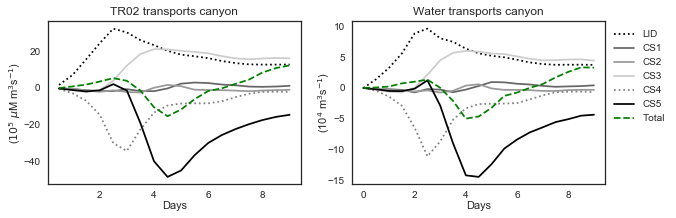

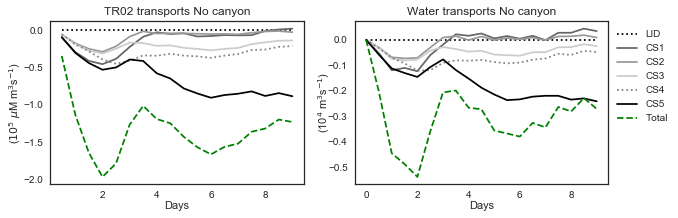

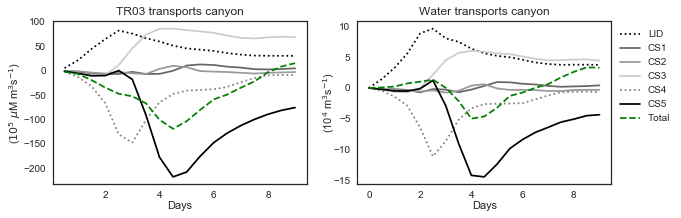

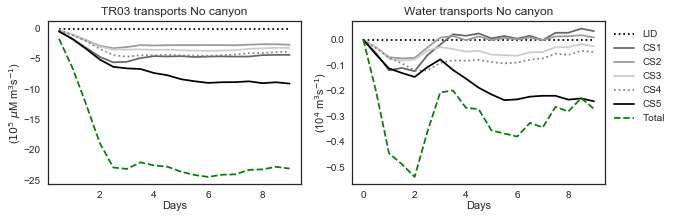

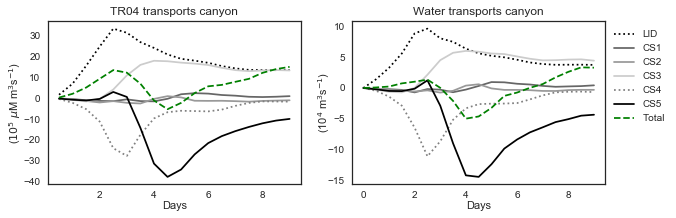

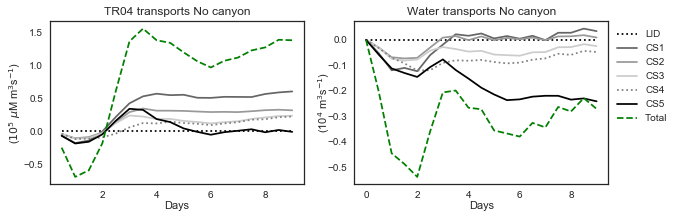

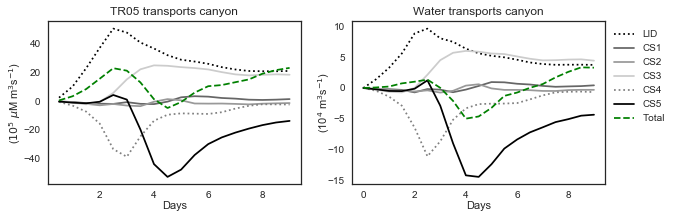

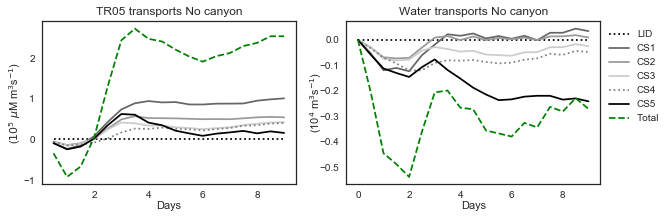

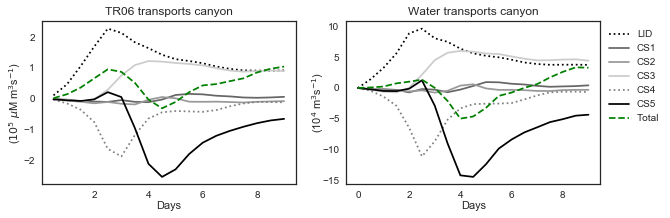

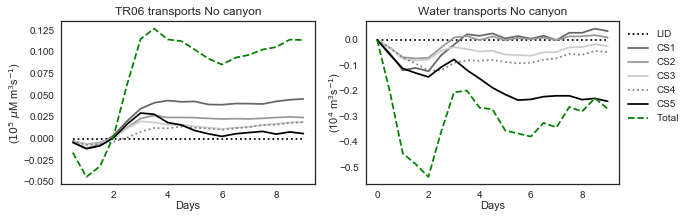

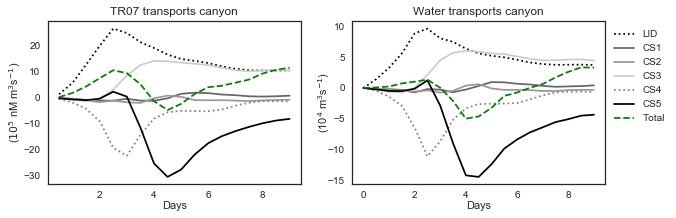

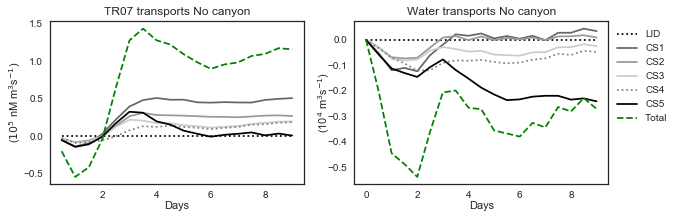

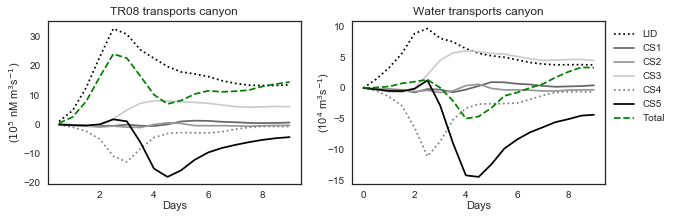

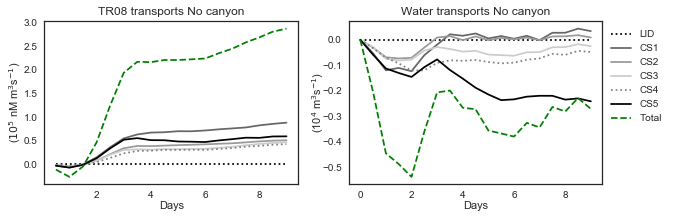

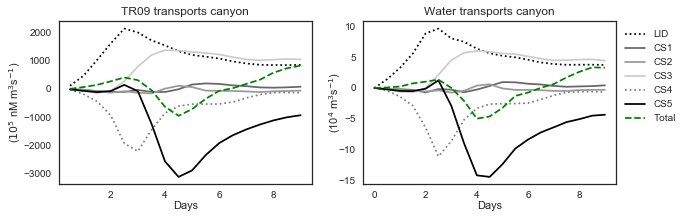

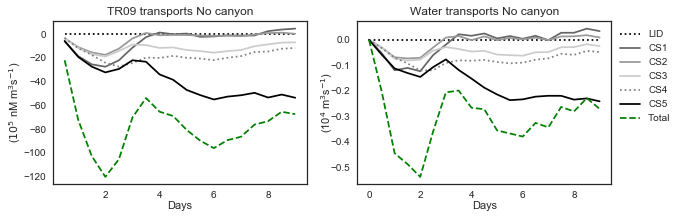

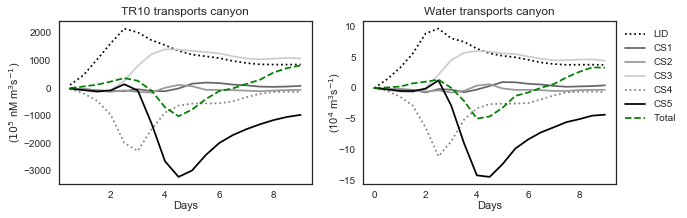

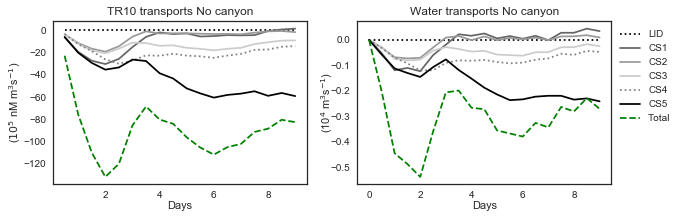

In [6]:
# Water
file2 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/water_CS_transports.nc')
fileNoC2 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/water_CS_transports.nc')
dfcan2 = xr.open_dataset(file2)
dfnoc2 = xr.open_dataset(fileNoC2)

units = ['($10^5$ $\mu$M m$^3$s$^{-1}$)','($10^5$ $\mu$M m$^3$s$^{-1}$)','($10^5$ $\mu$M m$^3$s$^{-1}$)',
        '($10^5$ $\mu$M m$^3$s$^{-1}$)','($10^5$ $\mu$M m$^3$s$^{-1}$)','($10^5$ $\mu$M m$^3$s$^{-1}$)',
        '($10^5$ nM m$^3$s$^{-1}$)','($10^5$ nM m$^3$s$^{-1}$)','($10^5$ nM m$^3$s$^{-1}$)','($10^5$ nM m$^3$s$^{-1}$)']
tracers = ['TR01', 'TR02','TR03','TR04','TR05','TR06','TR07','TR08','TR09', 'TR10']

for tr, unit in zip(tracers, units):
    # Tracers
    file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/adv%s_CS_transports.nc' %tr)
    filedif = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/dif%s_CS_transports.nc' %tr)
    fileNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/adv%s_CS_transports.nc' %tr)
    filedifNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/dif%s_CS_transports.nc' %tr)

    dfcan = xr.open_dataset(file)
    dfdif = xr.open_dataset(filedif)
    dfnoc = xr.open_dataset(fileNoC)
    dfnocdif = xr.open_dataset(filedifNoC)
 
    plot_transports(dfcan,dfdif,dfcan2, tr, 'canyon', unit)
    plot_transports(dfnoc,dfnocdif,dfnoc2, tr, 'No canyon', unit)
    

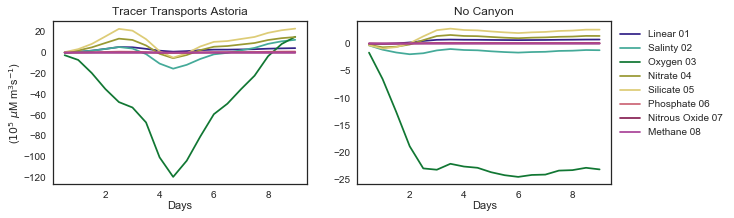

In [7]:
tracers = ['TR01', 'TR02','TR03','TR04','TR05','TR06','TR07','TR08', 'TR09', 'TR10']
factors = [1,1,1,1,1,1,1E-3,1E-3]
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499','brown','beige']

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))

  
for tr, fact, col, lab in zip(tracers, factors, colours, labels):
    file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/adv%s_CS_transports.nc' %tr)
    filedif = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/dif%s_CS_transports.nc' %tr)
    fileNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/adv%s_CS_transports.nc' %tr)
    filedifNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/dif%s_CS_transports.nc' %tr)

    dfcan = xr.open_dataset(file)
    dfdif = xr.open_dataset(filedif)
    dfnoc = xr.open_dataset(fileNoC)
    dfnocdif = xr.open_dataset(filedifNoC)
 
    ax0.plot(np.arange(1,19,1)/2.0,tot_trans(dfcan,dfdif)*fact/1E5,color=col, label=lab)
    ax1.plot(np.arange(1,19,1)/2.0,tot_trans(dfnoc,dfnocdif)*fact/1E5, color=col, label=lab)

ax0.set_xlabel('Days',labelpad=0.5)
ax1.set_xlabel('Days',labelpad=0.5)
ax0.set_ylabel('($10^5$ $\mu$M m$^3$s$^{-1}$)',labelpad=0.5)
ax0.set_title('Tracer Transports Astoria')
ax1.set_title('No Canyon')
ax1.legend(bbox_to_anchor=(1,1))



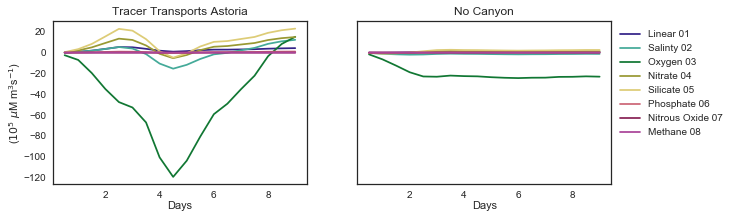

In [8]:
tracers = ['TR01', 'TR02','TR03','TR04','TR05','TR06','TR07','TR08']
factors = [1,1,1,1,1,1,1E-3,1E-3]
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499']

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3), sharey=True)

  
for tr, fact, col, lab in zip(tracers, factors, colours, labels):
    file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/adv%s_CS_transports.nc' %tr)
    filedif = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/dif%s_CS_transports.nc' %tr)
    fileNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/adv%s_CS_transports.nc' %tr)
    filedifNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/dif%s_CS_transports.nc' %tr)

    dfcan = xr.open_dataset(file)
    dfdif = xr.open_dataset(filedif)
    dfnoc = xr.open_dataset(fileNoC)
    dfnocdif = xr.open_dataset(filedifNoC)
 
    ax0.plot(np.arange(1,19,1)/2.0,tot_trans(dfcan,dfdif)*fact/1E5,color=col, label=lab)
    ax1.plot(np.arange(1,19,1)/2.0,tot_trans(dfnoc,dfnocdif)*fact/1E5, color=col, label=lab)

ax0.set_xlabel('Days',labelpad=0.5)
ax1.set_xlabel('Days',labelpad=0.5)
ax0.set_ylabel('($10^5$ $\mu$M m$^3$s$^{-1}$)',labelpad=0.5)
ax0.set_title('Tracer Transports Astoria')
ax1.set_title('No Canyon')
ax1.legend(bbox_to_anchor=(1,1))



### Slices - Mean transport days 5 to 9

In [9]:
t_slice = slice(10,20)
x_slice = slice(0,616)
x_slice_vert = slice(120,240)
y_slice_vert = slice(130,230)
z_slice = slice(0,80)
z_slice_zoom = slice(0,30)
y_ind = 130 # sb index
z_ind = 30 # sb index

In [10]:
def plot_CS_slice(t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind,
                  grid,Flux,FluxV):
    plt.rcParams['font.size'] = 8.0
    f = plt.figure(figsize = (12.5,4.5))

    gs = gspec.GridSpec(1, 2, width_ratios=[1,0.3])
    gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15,wspace=0.15,height_ratios=[1,1])

    ax2 = plt.subplot(gs1[0],xticks=[])
    ax3 = plt.subplot(gs1[1])
    ax4 = plt.subplot(gs[1])


    areas = (np.expand_dims(grid.dxF.isel(X=x_slice,Y=y_ind).data,0))*(np.expand_dims(grid.drF.isel(Z=z_slice).data,1))

    # Full shelf ---------------------------------------------------------------------------
    cnt=ax3.contourf(grid.X.isel(X=x_slice)/1000,
                     grid.Z.isel(Z=z_slice),
                     Flux.isel(Zmd000104=z_slice,X=x_slice)/areas,
                     16,cmap=cmo.cm.tarn,
                     vmax=np.max(Flux.isel(Zmd000104=z_slice,X=x_slice)/areas), 
                     vmin=-np.max(Flux.isel(Zmd000104=z_slice,X=x_slice)/areas))
    ax3.contourf(grid.X.isel(X=x_slice)/1000,
                 grid.Z.isel(Z=z_slice),
                 grid.HFacC.isel(Z=z_slice,Y=y_ind,X=x_slice),
                 [0,0.1], colors='#a99582')

    cbar_ax = f.add_axes([0.65, 0.126, 0.02, 0.355])
    cb=f.colorbar(cnt, cax=cbar_ax)
    cb.ax.xaxis.set_tick_params(pad=1.5)

    ax3.axhline(y=grid.Z[z_ind], linestyle=':',color='k')
    ax3.set_xlabel('Alongshelf distance / km',labelpad=0.5)
    ax3.set_ylabel('Depth / m',labelpad=0.5)

    ax3.text(0.87,0.9,'$\mu$M ms$^{-1}$',transform=ax3.transAxes)
    ax3.set_facecolor('#a99582')     

    # Zoom shelf   ---------------------------------------------------------------------------
    cnt = ax2.contourf(grid.X.isel(X=x_slice)/1000,
                       grid.Z.isel(Z=z_slice_zoom),
                       Flux.isel(Zmd000104=z_slice_zoom, X=x_slice)/areas[z_slice_zoom,:],
                       16,cmap=cmo.cm.tarn,
                       vmax=np.max(Flux.isel(Zmd000104=z_slice_zoom,X=x_slice)/areas[z_slice_zoom,:]), 
                       vmin=-np.max(Flux.isel(Zmd000104=z_slice_zoom,X=x_slice)/areas[z_slice_zoom,:]))
    ax2.contourf(grid.X.isel(X=x_slice)/1000,
                 grid.Z.isel(Z=z_slice_zoom),
                 grid.HFacC.isel(Z=z_slice_zoom,Y=y_ind,X=x_slice),
                 [0,0.1], colors='#a99582')

    cbar_ax2 = f.add_axes([0.65, 0.53, 0.02, 0.348])
    cb2=f.colorbar(cnt, cax=cbar_ax2)
    cb2.ax.yaxis.set_tick_params(pad=1.5)

    ax2.set_ylabel('Depth / m',labelpad=0.5)
    ax2.text(0.87,0.9,'$\mu$M ms$^{-1}$',transform=ax2.transAxes)    

    # Vertical section ---------------------------------------------------------------------------
    cnt=ax4.contourf(grid.X.isel(X=x_slice_vert)/1000,
                     grid.Y.isel(Y=y_slice_vert)/1000,
                     100*(FluxV.isel(X=x_slice_vert,Y=y_slice_vert).data)/(grid.rA[y_slice_vert,x_slice_vert]),
                     16,cmap=cmo.cm.tarn,
                     vmax= np.max(100*(FluxV.isel(X=x_slice_vert,Y=y_slice_vert).data)/(grid.rA[y_slice_vert,x_slice_vert])),
                     vmin=-np.max(100*(FluxV.isel(X=x_slice_vert,Y=y_slice_vert).data)/(grid.rA[y_slice_vert,x_slice_vert])))
    ax4.contourf(grid.X.isel(X=x_slice_vert)/1000, 
                 grid.Y.isel(Y=y_slice_vert)/1000,
                 grid.HFacC.isel(Z=z_ind,X=x_slice_vert,Y=y_slice_vert),
                 [0,0.1], colors='#a99582')

    cbar_ax3 = f.add_axes([0.737, 0.16, 0.17, 0.03])
    cb3=f.colorbar(cnt, cax=cbar_ax3, orientation='horizontal')#,ticks=[-2,-1,0,1,2,3,4])
    cb3.ax.yaxis.set_tick_params(pad=1.5)

    ax4.set_aspect(1)
    ax4.set_xlabel('Alongshelf distance / km',labelpad=0.5)
    ax4.set_ylabel('C-S / km',labelpad=0.5)
    ax4.text(0.6,0.85,'$10^{-2}$$\mu$M ms$^{-1}$',transform=ax4.transAxes)    
    #ax4.set_yticks([52,54,56,58,60])

    # General looks
    #ax0.text(0.5,0.1,'(a) Tracer transport',transform=ax0.transAxes)
    #ax1.text(0.5,0.1,'(b) Water transport',transform=ax1.transAxes)    
    #ax2.text(0.01,0.85,'(c)',transform=ax2.transAxes)
    #ax3.text(0.01,0.85,'(d)',transform=ax3.transAxes)    
    #ax4.text(0.02,0.85,'(e) LID',transform=ax4.transAxes)    

    #ax2.text(0.24,0.85,'CS2',transform=ax2.transAxes)
    #ax2.text(0.5,0.85,'CS3',transform=ax2.transAxes)
    #ax2.text(0.7,0.85,'CS4',transform=ax2.transAxes)


    plotCSPos(ax2,grid.X[60]/1000,grid.X[120]/1000,grid.X[240]/1000,grid.X[300]/1000, grid.X[360]/1000)
    plotCSPos(ax3,grid.X[60]/1000,grid.X[120]/1000,grid.X[240]/1000,grid.X[300]/1000, grid.X[360]/1000)

    #ax2.set_ylim(0,2.2)
    #ax3.set_ylim(0,15)
    ax3.tick_params(axis='x', pad=1)
    ax4.tick_params(axis='x', pad=1)

    ax2.tick_params(axis='y', pad=3)
    ax3.tick_params(axis='y', pad=3)
    ax4.tick_params(axis='y', pad=3)

    ax2.set_xlim(0,150)
    ax3.set_xlim(0,150)

Linear


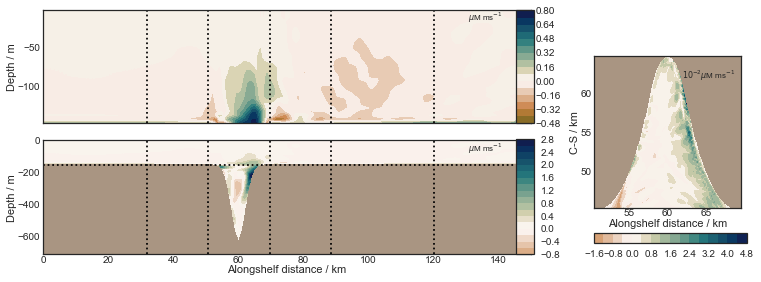

In [11]:
grid = xr.open_dataset(Grid)

flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/FluxTR01Glob.nc')
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr01[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr01[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr01[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr01[t_slice,z_ind,:,:]+flux.DFrETr01[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

plot_CS_slice(t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV)
print('Linear')

Salt


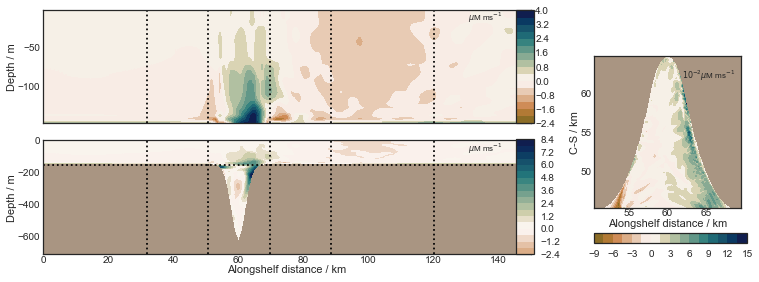

In [12]:
grid = xr.open_dataset(Grid)

flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/FluxTR02Glob.nc')
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr02[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr02[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr02[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr02[t_slice,z_ind,:,:]+flux.DFrETr02[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

plot_CS_slice(t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV)
print('Salt')

Oxygen


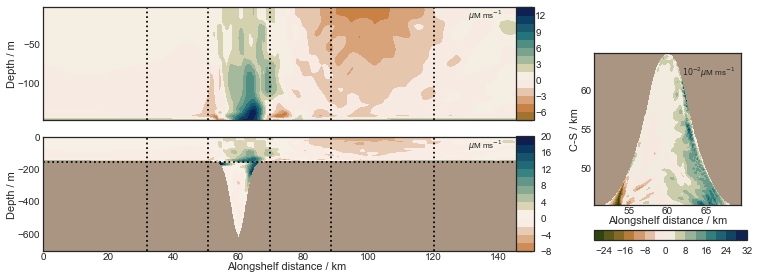

In [13]:
grid = xr.open_dataset(Grid)

flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/FluxTR03Glob.nc')
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr03[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr03[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr03[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr03[t_slice,z_ind,:,:]+flux.DFrETr03[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

plot_CS_slice(t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV)
print('Oxygen')

Nitrate


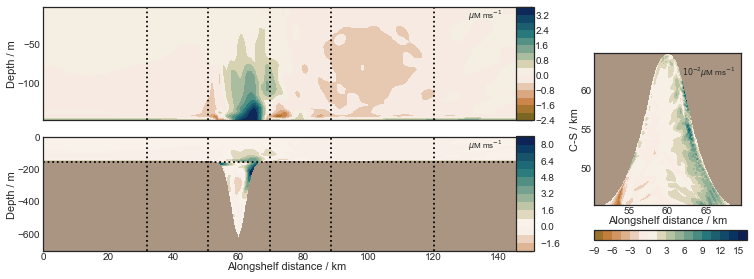

In [14]:
grid = xr.open_dataset(Grid)

flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/FluxTR04Glob.nc')
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr04[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr04[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr04[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr04[t_slice,z_ind,:,:]+flux.DFrETr04[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

plot_CS_slice(t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV)
print('Nitrate')

Silicate


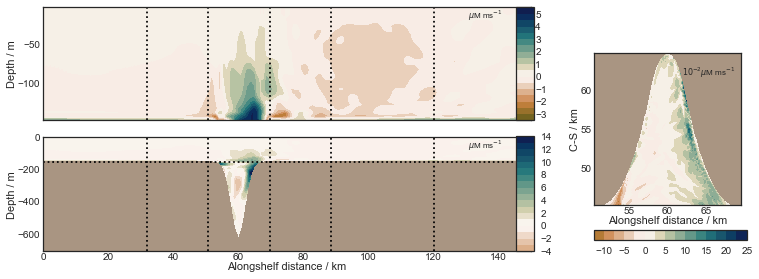

In [15]:
grid = xr.open_dataset(Grid)

flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/FluxTR05Glob.nc')
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr05[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr05[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr05[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr05[t_slice,z_ind,:,:]+flux.DFrETr05[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

plot_CS_slice(t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV)
print('Silicate')

Phosphate


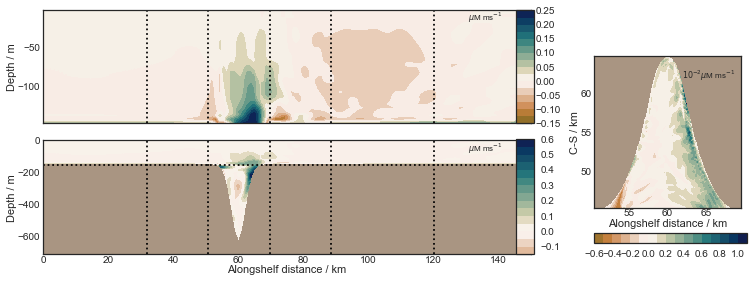

In [16]:
grid = xr.open_dataset(Grid)

flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/FluxTR06Glob.nc')
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr06[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr06[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr06[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr06[t_slice,z_ind,:,:]+flux.DFrETr06[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

plot_CS_slice(t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV)
print('Phosphate')

Nitrous Oxide


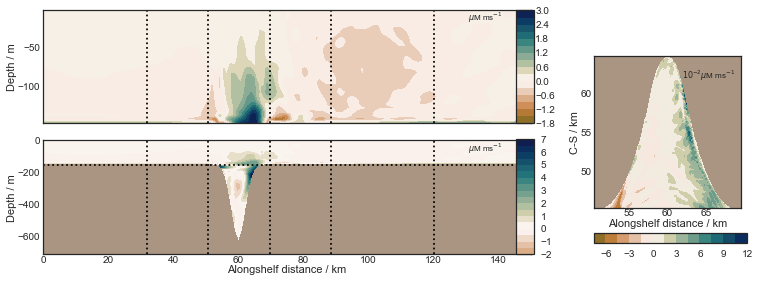

In [17]:
grid = xr.open_dataset(Grid)

flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/FluxTR07Glob.nc')
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr07[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr07[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr07[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr07[t_slice,z_ind,:,:]+flux.DFrETr07[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

plot_CS_slice(t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV)
print('Nitrous Oxide')

Methane


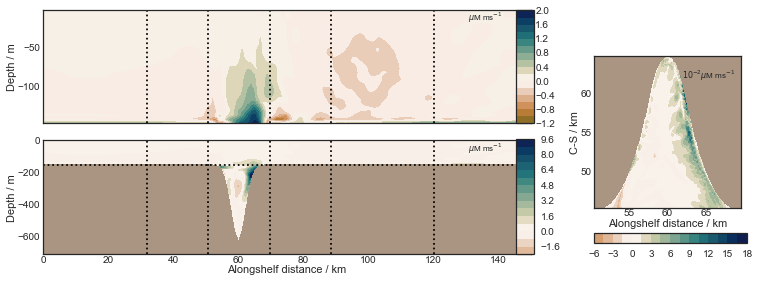

In [18]:
grid = xr.open_dataset(Grid)

flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/FluxTR08Glob.nc')
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr08[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr08[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr08[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr08[t_slice,z_ind,:,:]+flux.DFrETr08[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

plot_CS_slice(t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV)
print('Methane')

(0, 150)

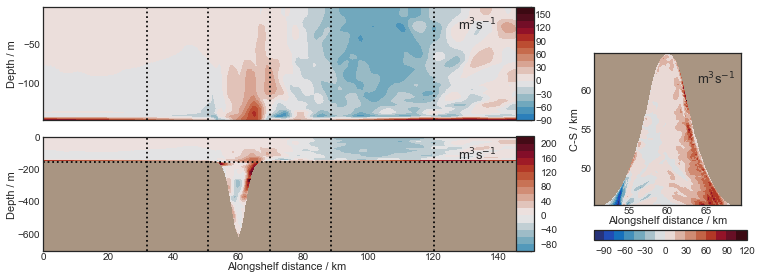

In [19]:
state = xr.open_dataset(State)
grid = xr.open_dataset(Grid)

plt.rcParams['font.size'] = 13.0
f = plt.figure(figsize = (12.5,4.5))

gs = gspec.GridSpec(1, 2, width_ratios=[1,0.3])
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15,wspace=0.15,height_ratios=[1,1])

ax2 = plt.subplot(gs1[0],xticks=[])
ax3 = plt.subplot(gs1[1])
ax4 = plt.subplot(gs[1])


areas = (np.expand_dims(grid.dxF.isel(X=x_slice,Y=y_ind).data,0))*(np.expand_dims(grid.drF.isel(Z=z_slice).data,1))
V_CS = (state.V[t_slice,:,y_ind,:]).mean(dim='T')
W_CS = (state.W[t_slice,z_ind,:,:]).mean(dim='T')

# Full shelf ---------------------------------------------------------------------------
cnt=ax3.contourf(grid.X.isel(X=x_slice)/1000,
                 grid.Z.isel(Z=z_slice),
                 (V_CS.isel(Z=z_slice,X=x_slice))*areas,
                 16,cmap=cmo.cm.balance,
                 vmax=np.max((V_CS.isel(Z=z_slice,X=x_slice))*areas), 
                 vmin=-np.max((V_CS.isel(Z=z_slice,X=x_slice))*areas))
ax3.contourf(grid.X.isel(X=x_slice)/1000,
             grid.Z.isel(Z=z_slice),
             grid.HFacS.isel(Z=z_slice,Yp1=y_ind,X=x_slice),
             [0,0.1], colors='#a99582')

cbar_ax = f.add_axes([0.65, 0.126, 0.02, 0.355])
cb=f.colorbar(cnt, cax=cbar_ax)
cb.ax.xaxis.set_tick_params(pad=1.5)

ax3.axhline(y=grid.Z[z_ind], linestyle=':',color='k')
ax3.set_xlabel('Alongshelf distance / km',labelpad=0.5)
ax3.set_ylabel('Depth / m',labelpad=0.5)

ax3.text(0.85,0.8,'m$^3$s$^{-1}$',transform=ax3.transAxes)
ax3.set_facecolor('#a99582')     

# Zoom shelf   ---------------------------------------------------------------------------
cnt = ax2.contourf(grid.X.isel(X=x_slice)/1000,
                   grid.Z.isel(Z=z_slice_zoom),
                   (V_CS.isel(Z=z_slice_zoom,X=x_slice))*areas[z_slice_zoom,:],
                   16,cmap=cmo.cm.balance,
                   vmax=np.max((V_CS.isel(Z=z_slice_zoom,X=x_slice))*areas[z_slice_zoom,:]), 
                   vmin=-np.max((V_CS.isel(Z=z_slice_zoom,X=x_slice))*areas[z_slice_zoom,:]))
ax2.contourf(grid.X.isel(X=x_slice)/1000,
             grid.Z.isel(Z=z_slice_zoom),
             grid.HFacS.isel(Z=z_slice_zoom,Yp1=y_ind,X=x_slice),
             [0,0.1], colors='#a99582')

cbar_ax2 = f.add_axes([0.65, 0.53, 0.02, 0.348])
cb2=f.colorbar(cnt, cax=cbar_ax2)
cb2.ax.yaxis.set_tick_params(pad=1.5)

ax2.set_ylabel('Depth / m',labelpad=0.5)
ax2.text(0.85,0.8,'m$^3$s$^{-1}$',transform=ax2.transAxes)    

# Vertical section ---------------------------------------------------------------------------
cnt=ax4.contourf(grid.X.isel(X=x_slice_vert)/1000,
                 grid.Y.isel(Y=y_slice_vert)/1000,
                 (W_CS.isel(X=x_slice_vert,Y=y_slice_vert)*(grid.rA[y_slice_vert,x_slice_vert])),
                 16,cmap=cmo.cm.balance,
                 vmax= np.max((W_CS.isel(X=x_slice_vert,Y=y_slice_vert)*(grid.rA[y_slice_vert,x_slice_vert]))),
                 vmin=-np.max((W_CS.isel(X=x_slice_vert,Y=y_slice_vert)*(grid.rA[y_slice_vert,x_slice_vert]))))
ax4.contourf(grid.X.isel(X=x_slice_vert)/1000, 
             grid.Y.isel(Y=y_slice_vert)/1000,
             grid.HFacC.isel(Z=z_ind,X=x_slice_vert,Y=y_slice_vert),
             [0,0.1], colors='#a99582')

cbar_ax3 = f.add_axes([0.737, 0.16, 0.17, 0.03])
cb3=f.colorbar(cnt, cax=cbar_ax3, orientation='horizontal')
cb3.ax.yaxis.set_tick_params(pad=1.5)

ax4.set_aspect(1)
ax4.set_xlabel('Alongshelf distance / km',labelpad=0.5)
ax4.set_ylabel('C-S / km',labelpad=0.5)
ax4.text(0.7,0.8,'m$^3$s$^{-1}$',transform=ax4.transAxes)    
#ax4.set_yticks([52,54,56,58,60])

plotCSPos(ax2,grid.X[60]/1000,grid.X[120]/1000,grid.X[240]/1000,grid.X[300]/1000, grid.X[360]/1000)
plotCSPos(ax3,grid.X[60]/1000,grid.X[120]/1000,grid.X[240]/1000,grid.X[300]/1000, grid.X[360]/1000)

ax3.tick_params(axis='x', pad=1)
ax4.tick_params(axis='x', pad=1)

ax2.tick_params(axis='y', pad=3)
ax3.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)

ax2.set_xlim(0,150)
ax3.set_xlim(0,150)

Whole shelf


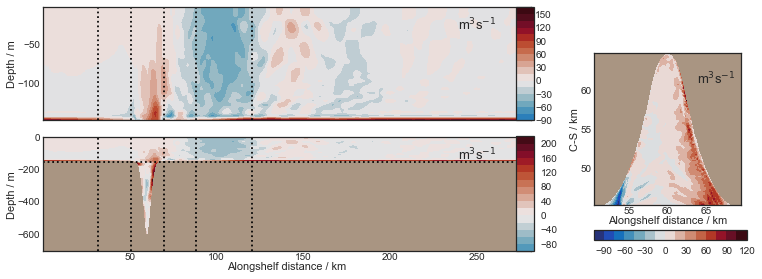

In [20]:
state = xr.open_dataset(State)
grid = xr.open_dataset(Grid)

plt.rcParams['font.size'] = 13.0
f = plt.figure(figsize = (12.5,4.5))

gs = gspec.GridSpec(1, 2, width_ratios=[1,0.3])
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15,wspace=0.15,height_ratios=[1,1])

ax2 = plt.subplot(gs1[0],xticks=[])
ax3 = plt.subplot(gs1[1])
ax4 = plt.subplot(gs[1])


areas = (np.expand_dims(grid.dxF.isel(X=x_slice,Y=y_ind).data,0))*(np.expand_dims(grid.drF.isel(Z=z_slice).data,1))
V_CS = (state.V[t_slice,:,y_ind,:]).mean(dim='T')
W_CS = (state.W[t_slice,z_ind,:,:]).mean(dim='T')

# Full shelf ---------------------------------------------------------------------------
cnt=ax3.contourf(grid.X.isel(X=x_slice)/1000,
                 grid.Z.isel(Z=z_slice),
                 (V_CS.isel(Z=z_slice,X=x_slice))*areas,
                 16,cmap=cmo.cm.balance,
                 vmax=np.max((V_CS.isel(Z=z_slice,X=x_slice))*areas), 
                 vmin=-np.max((V_CS.isel(Z=z_slice,X=x_slice))*areas))
ax3.contourf(grid.X.isel(X=x_slice)/1000,
             grid.Z.isel(Z=z_slice),
             grid.HFacS.isel(Z=z_slice,Yp1=y_ind,X=x_slice),
             [0,0.1], colors='#a99582')

cbar_ax = f.add_axes([0.65, 0.126, 0.02, 0.355])
cb=f.colorbar(cnt, cax=cbar_ax)
cb.ax.xaxis.set_tick_params(pad=1.5)

ax3.axhline(y=grid.Z[z_ind], linestyle=':',color='k')
ax3.set_xlabel('Alongshelf distance / km',labelpad=0.5)
ax3.set_ylabel('Depth / m',labelpad=0.5)

ax3.text(0.85,0.8,'m$^3$s$^{-1}$',transform=ax3.transAxes)
ax3.set_facecolor('#a99582')     

# Zoom shelf   ---------------------------------------------------------------------------
cnt = ax2.contourf(grid.X.isel(X=x_slice)/1000,
                   grid.Z.isel(Z=z_slice_zoom),
                   (V_CS.isel(Z=z_slice_zoom,X=x_slice))*areas[z_slice_zoom,:],
                   16,cmap=cmo.cm.balance,
                   vmax=np.max((V_CS.isel(Z=z_slice_zoom,X=x_slice))*areas[z_slice_zoom,:]), 
                   vmin=-np.max((V_CS.isel(Z=z_slice_zoom,X=x_slice))*areas[z_slice_zoom,:]))
ax2.contourf(grid.X.isel(X=x_slice)/1000,
             grid.Z.isel(Z=z_slice_zoom),
             grid.HFacS.isel(Z=z_slice_zoom,Yp1=y_ind,X=x_slice),
             [0,0.1], colors='#a99582')

cbar_ax2 = f.add_axes([0.65, 0.53, 0.02, 0.348])
cb2=f.colorbar(cnt, cax=cbar_ax2)
cb2.ax.yaxis.set_tick_params(pad=1.5)

ax2.set_ylabel('Depth / m',labelpad=0.5)
ax2.text(0.85,0.8,'m$^3$s$^{-1}$',transform=ax2.transAxes)    

# Vertical section ---------------------------------------------------------------------------
cnt=ax4.contourf(grid.X.isel(X=x_slice_vert)/1000,
                 grid.Y.isel(Y=y_slice_vert)/1000,
                 (W_CS.isel(X=x_slice_vert,Y=y_slice_vert)*(grid.rA[y_slice_vert,x_slice_vert])),
                 16,cmap=cmo.cm.balance,
                 vmax= np.max((W_CS.isel(X=x_slice_vert,Y=y_slice_vert)*(grid.rA[y_slice_vert,x_slice_vert]))),
                 vmin=-np.max((W_CS.isel(X=x_slice_vert,Y=y_slice_vert)*(grid.rA[y_slice_vert,x_slice_vert]))))
ax4.contourf(grid.X.isel(X=x_slice_vert)/1000, 
             grid.Y.isel(Y=y_slice_vert)/1000,
             grid.HFacC.isel(Z=z_ind,X=x_slice_vert,Y=y_slice_vert),
             [0,0.1], colors='#a99582')

cbar_ax3 = f.add_axes([0.737, 0.16, 0.17, 0.03])
cb3=f.colorbar(cnt, cax=cbar_ax3, orientation='horizontal')
cb3.ax.yaxis.set_tick_params(pad=1.5)

ax4.set_aspect(1)
ax4.set_xlabel('Alongshelf distance / km',labelpad=0.5)
ax4.set_ylabel('C-S / km',labelpad=0.5)
ax4.text(0.7,0.8,'m$^3$s$^{-1}$',transform=ax4.transAxes)    
#ax4.set_yticks([52,54,56,58,60])

plotCSPos(ax2,grid.X[60]/1000,grid.X[120]/1000,grid.X[240]/1000,grid.X[300]/1000, grid.X[360]/1000)
plotCSPos(ax3,grid.X[60]/1000,grid.X[120]/1000,grid.X[240]/1000,grid.X[300]/1000, grid.X[360]/1000)

ax3.tick_params(axis='x', pad=1)
ax4.tick_params(axis='x', pad=1)

ax2.tick_params(axis='y', pad=3)
ax3.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)
print('Whole shelf')